In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'driver_imgs_list.csv', 'sample_submission.csv']


In [2]:
!pip install tensorflow-gpu==2.0.0-alpha0;

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

2.0.0-alpha0


True

In [4]:
# defining the path and classes.
directory = '../input/train'
test_directory = '../input/test/'
classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

In [5]:
# defining a shape to be used for our models.
img_size = 240

In [6]:
import cv2
import matplotlib.pyplot as plt

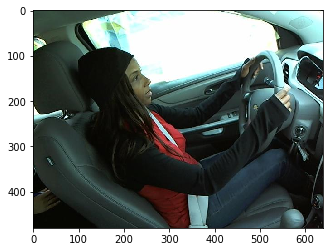

In [26]:
# Train class image for display.
for i in classes:
    path = os.path.join(directory,i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
        RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img)
        plt.show()
        break
    break

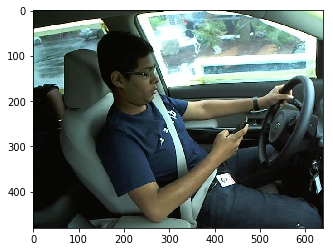

In [27]:
# Test class image for display.
test_array = []
for img in os.listdir(test_directory):
    img_array = cv2.imread(os.path.join(test_directory,img),cv2.IMREAD_COLOR)
    RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    test_array = RGB_img
    plt.imshow(RGB_img)
    plt.show()
    break

In [28]:
# checkking image size using shape.
print(img_array.shape)

(480, 640, 3)


(240, 240, 3)


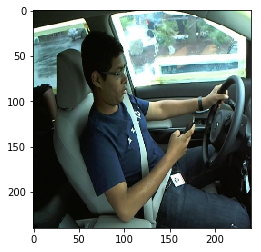

In [30]:
# trying out the resize image functionality
new_img = cv2.resize(test_array,(img_size,img_size))
print(new_img.shape)
plt.imshow(new_img)
plt.show()


In [7]:
# creating a training dataset.
training_data = []
i = 0
def create_training_data():
    for category in classes:
        path = os.path.join(directory,category)
        class_num = classes.index(category)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
            RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            new_img = cv2.resize(RGB_img,(img_size,img_size))
            training_data.append([new_img,class_num])

In [8]:
create_training_data()

In [ ]:
print(len(training_data))

In [9]:
random.shuffle(training_data)
x = []
y = []

In [10]:
for features, label in training_data:
    x.append(features)
    y.append(label)

In [11]:
len(x),len(y)

(22424, 22424)

In [12]:
x[0].shape

(240, 240, 3)

In [13]:
len(x)

22424

In [14]:
x = np.array(x).reshape(-1,img_size,img_size,3)
x[0].shape

(240, 240, 3)

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=96)

In [16]:
del x,y

In [17]:
import gc
gc.collect()

10

In [18]:
from tensorflow.keras import utils

In [19]:
Y_train = utils.to_categorical(y_train,num_classes=10)
Y_test = utils.to_categorical(y_test,num_classes=10)

In [20]:
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization

In [21]:
model = models.Sequential()
## CNN 1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(240,240,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))
## CNN 2
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.3))
## CNN 3
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.5))
## Dense & Output
model.add(Flatten())
model.add(Dense(units = 512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 238, 32)      896       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 238, 238, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 238, 238, 32)      9248      
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 238, 238, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 119, 119, 64)      1

In [34]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
callback = [callbacks.EarlyStopping(monitor='val_accuracy',patience=5)]
batch_size = 70
n_epochs = 15

In [35]:
results = model.fit(x_train,Y_train,
                    batch_size=batch_size,epochs=n_epochs,
                    verbose=1,
                    validation_data=(x_test,Y_test),
                    callbacks=callback)

Train on 15696 samples, validate on 6728 samples
Epoch 1/15
15696/15696 [==============================] - 89s 6ms/sample - loss: 0.0465 - accuracy: 0.9855 - val_loss: 0.0503 - val_accuracy: 0.9869
Epoch 2/15
15696/15696 [==============================] - 85s 5ms/sample - loss: 0.0371 - accuracy: 0.9876 - val_loss: 0.0433 - val_accuracy: 0.9906
Epoch 3/15
15696/15696 [==============================] - 85s 5ms/sample - loss: 0.0342 - accuracy: 0.9891 - val_loss: 0.0479 - val_accuracy: 0.9903
Epoch 4/15
15696/15696 [==============================] - 85s 5ms/sample - loss: 0.0196 - accuracy: 0.9931 - val_loss: 0.0469 - val_accuracy: 0.9881
Epoch 5/15
15696/15696 [==============================] - 86s 5ms/sample - loss: 0.0292 - accuracy: 0.9898 - val_loss: 0.0650 - val_accuracy: 0.9826
Epoch 6/15
15696/15696 [==============================] - 85s 5ms/sample - loss: 0.0199 - accuracy: 0.9940 - val_loss: 0.0268 - val_accuracy: 0.9941
Epoch 7/15
15696/15696 [==============================] -

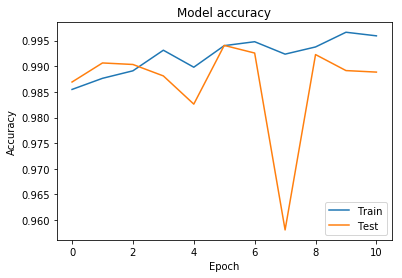

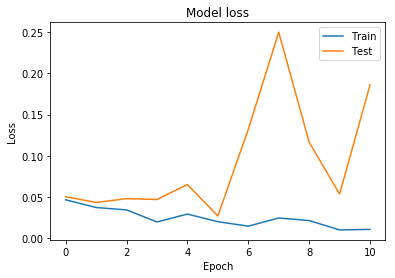

In [36]:
# Plot training & validation accuracy values
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Predict

In [37]:
pred= model.predict_classes(x_test)

## Confusion Matrix

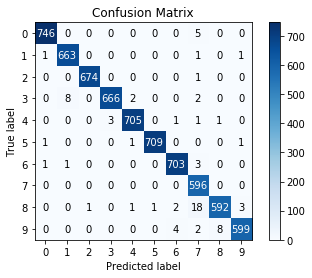

In [38]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Classification Report

In [39]:
from sklearn.metrics import classification_report 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       751
           1       0.99      1.00      0.99       666
           2       1.00      1.00      1.00       675
           3       1.00      0.98      0.99       678
           4       0.99      0.99      0.99       711
           5       1.00      1.00      1.00       712
           6       0.99      0.99      0.99       708
           7       0.95      1.00      0.97       596
           8       0.99      0.96      0.97       618
           9       0.99      0.98      0.98       613

   micro avg       0.99      0.99      0.99      6728
   macro avg       0.99      0.99      0.99      6728
weighted avg       0.99      0.99      0.99      6728



## Classes Definitions
    c0: safe driving
    c1: texting - right
    c2: talking on the phone - right
    c3: texting - left
    c4: talking on the phone - left
    c5: operating the radio
    c6: drinking
    c7: reaching behind
    c8: hair and makeup
    c9: talking to passenger

## Testing using random image

../input/test/img_86516.jpg
Prediction : [8]


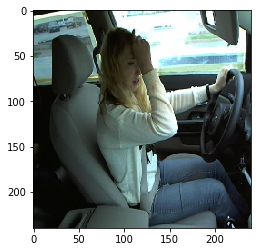

In [92]:
random_filename = random.choice([
    x for x in os.listdir(test_directory)
    if os.path.isfile(os.path.join(test_directory, x))])
random_filename=test_directory+random_filename
print(random_filename)
img_array = cv2.imread(random_filename,cv2.IMREAD_COLOR)
RGB_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
new_img = cv2.resize(RGB_img,(img_size,img_size))
print('Prediction : {}'.format(model.predict_classes(new_img.reshape(-1,img_size,img_size,3))))
plt.imshow(new_img)
plt.show()


In [87]:
model.save_weights('./driverdistraction_lr_weights.h5', overwrite=True)

In [ ]:
model.save('./driverdistraction.h5')